In [1]:
# import required libraries for dataframe and visualization

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import plotly as py
import plotly.graph_objs as go

# import required libraries for clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import warnings
import os
warnings.filterwarnings("ignore")
py.offline.init_notebook_mode(connected = True)

In [2]:
retail = pd.read_csv("Online Retail.csv")
retail.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,1/12/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,1/12/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,1/12/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,1/12/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,1/12/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,1/12/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,1/12/2010 8:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,1/12/2010 8:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,1/12/2010 8:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,1/12/2010 8:34,1.69,13047.0,United Kingdom


In [3]:
retail.shape

(541909, 8)

In [ ]:
retail.describe()

In [ ]:
retail.isnull().sum()

In [ ]:
# Calculating the Missing Values % contribution in DF

df_null = round(100*(retail.isnull().sum())/len(retail), 2)
df_null

In [4]:
# Droping rows having missing values

retail = retail.dropna()
retail.shape

(406829, 8)

In [5]:
# Changing the datatype of Customer Id as per Business understanding

retail['CustomerID'] = retail['CustomerID'].astype(str)

In [6]:
retail = retail[(retail['Country']=='United Kingdom') & (retail['Quantity'] > 0)]

In [7]:
# New Attribute : Monetary

retail['Amount'] = retail['Quantity']*retail['UnitPrice']
rfm_m = retail.groupby('CustomerID')['Amount'].sum()
rfm_m = rfm_m.reset_index()
rfm_m

,CustomerID,Amount
0,12346.0,77183.60
1,12747.0,4196.01
2,12748.0,33719.73
3,12749.0,4090.88
4,12820.0,942.34
...,...,...
3916,18280.0,180.60
3917,18281.0,80.82
3918,18282.0,178.05
3919,18283.0,2094.88


In [8]:
# New Attribute : Frequency

rfm_f = retail.groupby('CustomerID')['InvoiceNo'].nunique()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['CustomerID', 'Frequency']
rfm_f.head(20)

,CustomerID,Frequency
0,12346.0,1
1,12747.0,11
2,12748.0,210
3,12749.0,5
4,12820.0,4
5,12821.0,1
6,12822.0,2
7,12823.0,5
8,12824.0,1
9,12826.0,7


In [9]:
# Merging the two dfs

rfm = pd.merge(rfm_m,rfm_f,how='inner',on='CustomerID')
rfm.head()

,CustomerID,Amount,Frequency
0,12346.0,77183.60,1
1,12747.0,4196.01,11
2,12748.0,33719.73,210
3,12749.0,4090.88,5
4,12820.0,942.34,4


In [10]:
# New Attribute : Recency

# Convert to datetime to proper datatype

retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'],format='%d/%m/%Y %H:%M')
# Compute the maximum date to know the last transaction date

max_date = max(retail['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:49:00')

In [11]:
# Compute the difference between max date and transaction date

retail['Diff'] = max_date - retail['InvoiceDate']
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:23:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:23:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:23:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:23:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:23:00


In [12]:
rfm_r = retail.groupby('CustomerID')['Diff'].min()
rfm_r = rfm_r.reset_index()

rfm_r

,CustomerID,Diff
0,12346.0,325 days 02:48:00
1,12747.0,1 days 22:15:00
2,12748.0,0 days 00:29:00
3,12749.0,3 days 02:53:00
4,12820.0,2 days 21:37:00
...,...,...
3916,18280.0,277 days 02:57:00
3917,18281.0,180 days 01:56:00
3918,18282.0,7 days 01:06:00
3919,18283.0,3 days 00:47:00


In [13]:
rfm_r['Diff'] = rfm_r['Diff'].dt.days
rfm_r

,CustomerID,Diff
0,12346.0,325
1,12747.0,1
2,12748.0,0
3,12749.0,3
4,12820.0,2
...,...,...
3916,18280.0,277
3917,18281.0,180
3918,18282.0,7
3919,18283.0,3


In [14]:
rfm = pd.merge(rfm,rfm_r,how='inner', on='CustomerID')
rfm = rfm.rename({'Diff':'Recency'},axis='columns')
rfm

,CustomerID,Amount,Frequency,Recency
0,12346.0,77183.60,1,325
1,12747.0,4196.01,11,1
2,12748.0,33719.73,210,0
3,12749.0,4090.88,5,3
4,12820.0,942.34,4,2
...,...,...,...,...
3916,18280.0,180.60,1,277
3917,18281.0,80.82,1,180
3918,18282.0,178.05,2,7
3919,18283.0,2094.88,16,3


In [ ]:
rfm.shape

In [27]:
# Rescaling the attributes

rfm_df = rfm[['Amount', 'Frequency', 'Recency']]
rfm_df.head(20)

,Amount,Frequency,Recency
0,77183.60,1,325
1,4196.01,11,1
2,33719.73,210,0
3,4090.88,5,3
4,942.34,4,2
5,92.72,1,213
6,948.88,2,70
7,1759.50,5,74
8,397.12,1,59
9,1474.72,7,2


In [16]:
# Instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(3921, 3)

In [17]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_df_scaled.head()

,Amount,Frequency,Recency
0,10.068174,-0.450546,2.349480
1,0.311738,0.937411,-0.906268
2,4.258248,28.557767,-0.916317
3,0.297685,0.104637,-0.886171
4,-0.123189,-0.034159,-0.896220


In [18]:
inertia = []
for n in range(1 , 11):
    algorithm = KMeans(n_clusters = n  ,max_iter=50)
    algorithm.fit(rfm_df)
    inertia.append(algorithm.inertia_)

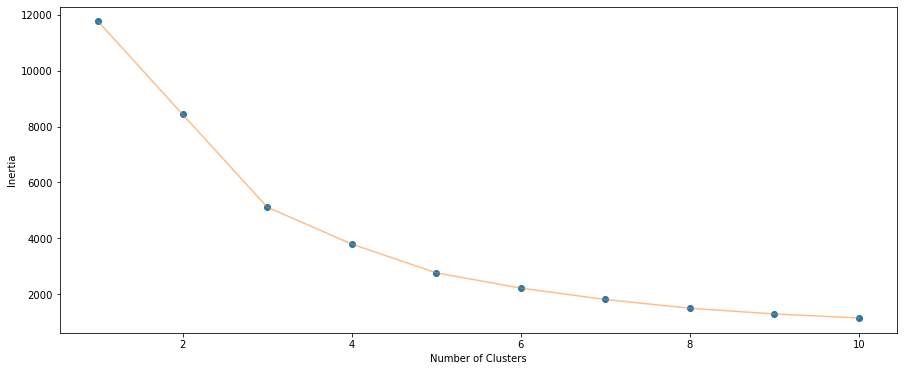

In [19]:
plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(1 , 11) , inertia , 'o')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()

In [20]:
# algorithm = (KMeans(n_clusters = 3 ,init='k-means++', n_init = 10 ,max_iter=300, 
#                         tol=0.0001,  random_state= 111  , algorithm='elkan') )
algorithm = KMeans(n_clusters=3, max_iter=50)
algorithm.fit(rfm_df_scaled)
labels3 = algorithm.labels_
centroids1 = algorithm.cluster_centers_

In [21]:
centroids1

array([[-0.01083418,  0.06461226, -0.51565906],
       [-0.18406518, -0.36855616,  1.52755037],
       [ 9.30768615,  7.73236885, -0.73150998]])

In [33]:
labels3

In [22]:
#Amount	Frequency	Recency

rfm['labels3'] =  labels3
trace1 = go.Scatter3d(
    x= rfm['Amount'],
    y= rfm['Frequency'],
    z= rfm['Recency'],
    mode='markers',
     marker=dict(
        color = rfm['labels3'], 
        size= 20,
        line=dict(
            color= rfm['labels3'],
            width= 12
        ),
        opacity=0.8
     )
)
data = [trace1]
layout = go.Layout(
#     margin=dict(
#         l=0,
#         r=0,
#         b=0,
#         t=0
#     )
    title= 'Clusters',
    scene = dict(
            xaxis = dict(title  = 'Amount'),
            yaxis = dict(title  = 'Frequency'),
            zaxis = dict(title  = 'Recency')
        )
)
fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

In [23]:
rfm.groupby('labels3')['labels3'].count()

labels3
0    2906
1     992
2      23
Name: labels3, dtype: int64

In [24]:
rfm.head()

,CustomerID,Amount,Frequency,Recency,labels3
0,12346.0,77183.60,1,325,2
1,12747.0,4196.01,11,1,0
2,12748.0,33719.73,210,0,2
3,12749.0,4090.88,5,3,0
4,12820.0,942.34,4,2,0


In [26]:
rfm.to_csv('retail.csv',index=False)

<AxesSubplot:xlabel='labels3', ylabel='Amount'>

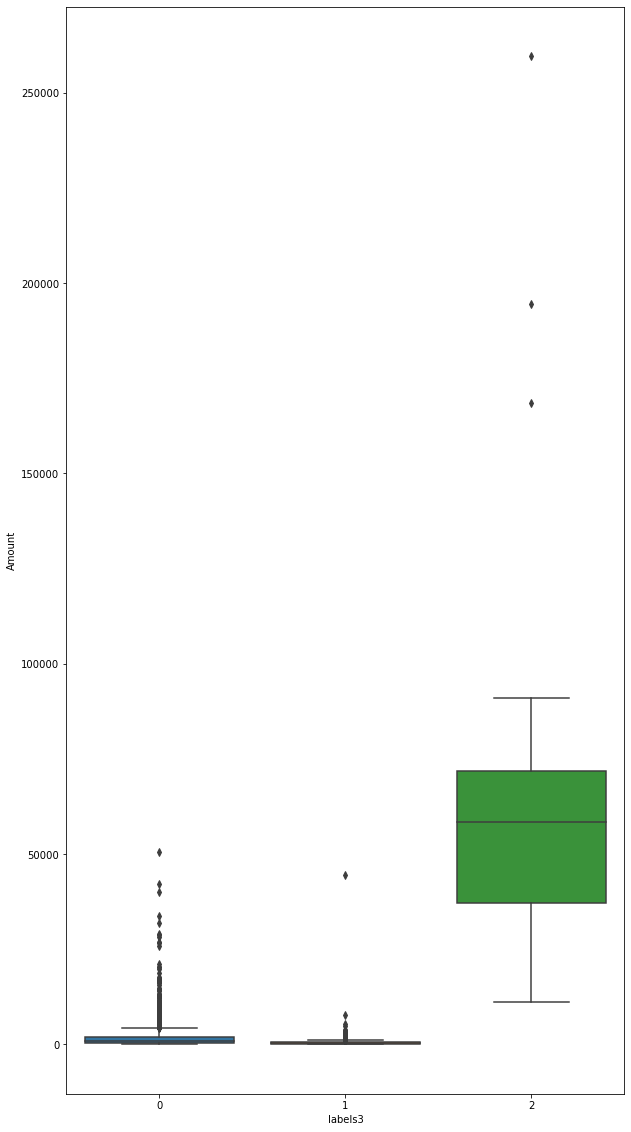

In [37]:
plt.rcParams['figure.figsize'] = [10,20]
sns.boxplot(x='labels3', y='Amount', data=rfm)